In [1]:
EXPERIMENT = '05-14'
N_SPLITS = 5
SEED = 1
CLIP_UPPER_RATE = 1.5
CLIP_LOWER_RATE = 1.0
Y_THRESHOLD = 200

In [2]:
from collections import defaultdict
import configparser
from functools import partial
from itertools import chain
import json
import logging
import os
import pickle
import re
import sys
import time

SINCE = time.time()

from catboost import CatBoostClassifier
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error as mse, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearnex import patch_sklearn

config = configparser.ConfigParser()
INI_FILEPATH = os.path.join(os.path.expanduser('~'), 'aiquest2021-assesment', 'config.ini')
config.read(INI_FILEPATH)
if config['FOLDER']['SCRIPTS'] not in sys.path:
    sys.path.append(config['FOLDER']['SCRIPTS'])
from logging_util import get_logger, timer
from feature_engineering import make_or_load_features
from text_feature_extraction import make_or_load_vector

In [3]:
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [4]:
output_dir = os.path.join(config['FOLDER']['EXPERIMENTS'], EXPERIMENT)
os.makedirs(output_dir)

In [5]:
logger = get_logger(__name__, os.path.join(output_dir, 'log.log'))

# Loading

In [6]:
with timer('Load dataset', logger):
    train = pd.read_csv(os.path.join(config['FOLDER']['INPUT'], 'train.csv'))
    test = pd.read_csv(os.path.join(config['FOLDER']['INPUT'], 'test.csv'))
    sample_submit = pd.read_csv(os.path.join(config['FOLDER']['INPUT'], 'sample_submit.csv'))

# Feature engineering

In [7]:
train_path = os.path.join(config['FOLDER']['FEATURES'], 'train_features.csv')
test_path = os.path.join(config['FOLDER']['FEATURES'], 'test_features.csv')

In [8]:
X, X_test = make_or_load_features(train, test, train_path, test_path, logger)

In [9]:
X

,id,accommodates,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,host_has_profile_pic,...,zipcode_1st_digit,zipcode5,zipcode_imputed,has_thumbnail,first_review_year,first_review_month,host_since_year,host_since_month,last_review_year,last_review_month
0,0,6,2.0,0,1.0,4.0,0,0,1,1,...,0,0,0,1,2016.0,7.0,2016.0,7.0,2016.0,7.0
1,1,2,1.0,0,1.0,1.0,1,1,1,1,...,1,1,0,0,2016.0,9.0,2015.0,12.0,2017.0,3.0
2,2,2,2.0,0,1.0,1.0,1,2,1,1,...,2,2,1,0,2016.0,6.0,2016.0,5.0,2017.0,8.0
3,3,2,1.0,0,1.0,1.0,1,3,1,1,...,0,3,0,1,2014.0,3.0,2012.0,6.0,2017.0,9.0
4,4,2,1.0,0,1.0,1.0,1,2,1,1,...,2,4,0,0,2015.0,8.0,2015.0,3.0,2017.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55578,55578,4,1.5,0,1.0,1.0,1,2,1,1,...,2,95,0,0,2013.0,2.0,2013.0,1.0,2017.0,9.0
55579,55579,2,1.0,0,1.0,1.0,2,4,0,1,...,3,181,0,0,2015.0,11.0,2015.0,1.0,2016.0,10.0
55580,55580,2,1.0,0,1.0,1.0,0,3,1,1,...,0,33,0,0,2016.0,3.0,2016.0,2.0,2017.0,4.0
55581,55581,1,1.5,0,1.0,1.0,2,0,1,1,...,0,251,0,0,2016.0,10.0,2016.0,4.0,2017.0,4.0


In [10]:
X_test

,id,accommodates,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,host_has_profile_pic,...,zipcode_1st_digit,zipcode5,zipcode_imputed,has_thumbnail,first_review_year,first_review_month,host_since_year,host_since_month,last_review_year,last_review_month
0,0,6,2.0,0,2.0,2.0,1,5,1,1,...,4,88,0,0,2017.0,1.0,2016.0,8.0,2017.0,9.0
1,1,3,1.0,0,1.0,1.0,2,0,1,1,...,0,16,0,0,2016.0,8.0,2014.0,9.0,2017.0,5.0
2,2,2,1.0,0,0.0,1.0,0,2,0,1,...,2,90,0,0,NaN,NaN,2012.0,10.0,NaN,NaN
3,3,4,1.0,0,1.0,2.0,1,2,0,1,...,2,44,0,0,NaN,NaN,2013.0,1.0,NaN,NaN
4,4,3,1.5,0,1.0,2.0,1,0,1,1,...,0,129,0,0,2015.0,8.0,2014.0,12.0,2016.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18523,18523,4,1.0,0,2.0,2.0,1,2,1,1,...,2,109,0,0,NaN,NaN,2009.0,11.0,NaN,NaN
18524,18524,2,1.0,0,2.0,1.0,0,4,0,1,...,3,22,0,1,2017.0,1.0,2017.0,1.0,2017.0,4.0
18525,18525,5,1.5,0,2.0,2.0,0,4,1,1,...,3,181,0,0,NaN,NaN,2014.0,9.0,NaN,NaN
18526,18526,2,1.0,0,1.0,2.0,1,2,1,1,...,2,158,0,0,2016.0,4.0,2014.0,3.0,2017.0,5.0


In [11]:
X.columns = [re.sub(r"[:;/']", '', c) for c in X.columns]
X_test.columns = [re.sub(r"[:;/']", '', c) for c in X.columns]

In [12]:
# Clustering
area_features = ['latitude', 'longitude']

# Onehot encoding
categorical_features = ['cancellation_policy', 'bed_type', 'city', 'neighbourhood', 'property_type',
                        'room_type', 'zipcode5', 'zipcode_1st_digit']

# They do not need to be encoded
int_flag_features = ['cleaning_fee', 'host_has_profile_pic', 'host_identity_verified',
                     'instant_bookable', 'has_thumbnail', 'zipcode_imputed']

# Already one-hot style
amenity_onehot_features = [c for c in X.columns if c.startswith('has_') and c.endswith('_amenity')]

discrete_features = categorical_features + int_flag_features + amenity_onehot_features

# Scaling, transformation
continuous_features = [
    c for c in X.columns
    if c not in discrete_features + area_features + ['id', 'y']
]

In [13]:
%%time
# Reduce dimension & whitening
## training
decomposer = PCA(n_components=0.8, random_state=SEED, whiten=True).fit(X[amenity_onehot_features])
X_amenity_components = decomposer.transform(X[amenity_onehot_features])
amenity_components_columns = [f'amenity_x{i + 1}' for i in range(decomposer.n_components_)]
X_amenity_components = pd.DataFrame(data=X_amenity_components,
                                    columns=amenity_components_columns)
X = pd.concat([X, X_amenity_components], axis=1)
# X.drop(columns=amenity_onehot_features, inplace=True)
X_test_amenity_components = decomposer.transform(X_test[amenity_onehot_features])
X_test_amenity_components = pd.DataFrame(data=X_test_amenity_components,
                                         columns=amenity_components_columns)
X_test = pd.concat([X_test, X_test_amenity_components], axis=1)
# X_test.drop(columns=amenity_onehot_features, inplace=True)

Wall time: 542 ms


In [14]:
f = lambda s1, s2: ' '.join([s1, s2])
train['name+description'] = np.vectorize(f)(train['name'], train['description'])
test['name+description'] = np.vectorize(f)(test['name'], test['description'])

In [15]:
%%time
vec_train, vec_test = make_or_load_vector(train=train,
                                          test=test,
                                          feature_dir=config['FOLDER']['FEATURES'],
                                          logger=logger,
                                          text_column='name+description',
                                          embedder='lda_count',
                                          overwrite=True,
                                          random_state=85)

Wall time: 4min 41s


In [16]:
%%time
vec_columns = vec_train.columns.tolist()

Wall time: 0 ns


In [17]:
%%time
X = pd.concat([X, vec_train], axis=1)
X_test = pd.concat([X_test, vec_test], axis=1)
X.shape, X_test.shape

Wall time: 67.2 ms


((55583, 285), (18528, 285))

In [18]:
passthrough_features = amenity_onehot_features \
                     + amenity_components_columns \
                     + int_flag_features \
                     + area_features \
                     + vec_columns

In [19]:
def get_classifier(continuous_features, discrete_features, passthrough_features, random_state):
    continuous_preprocessor = Pipeline(
        steps=[
            ('imputer', SimpleImputer(strategy='median'))
        ]
    )
    categorical_preprocessor = OneHotEncoder(handle_unknown='ignore')
    preprocessor = ColumnTransformer(
        transformers=[
            ('categorical', categorical_preprocessor, continuous_features),
            ('continuous', continuous_preprocessor, discrete_features),
            ('others', 'passthrough', passthrough_features)
        ],
        sparse_threshold=0
    )
    return Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('classifier', ComplementNB())
        ]
    )

# Cross validation

## Preparation

In [20]:
y_min, y_max = train['y'].min(), train['y'].max()  # clipping に必要

In [21]:
# ターゲットは対数変換する
y = train.set_index('id').loc[X['id']]['y']
y_log = np.log(y)
y_log

id
0        4.927254
1        3.737670
2        4.174387
3        5.111988
4        5.105945
           ...   
55578    5.828946
55579    3.401197
55580    4.605170
55581    3.637586
55582    3.912023
Name: y, Length: 55583, dtype: float64

In [22]:
# Stratified K-fold 用
y_labels = pd.cut(y_log, bins=3, labels=range(3))
y_labels

id
0        1
1        1
2        1
3        2
4        2
        ..
55578    2
55579    1
55580    1
55581    1
55582    1
Name: y, Length: 55583, dtype: category
Categories (3, int64): [0 < 1 < 2]

In [23]:
y_threshold = np.log(Y_THRESHOLD)
y_threshold

5.298317366548036

In [24]:
id_test = X_test['id'].values
id_test

array([    0,     1,     2, ..., 18525, 18526, 18527], dtype=int64)

In [25]:
train.set_index('id', inplace=True)

In [26]:
@np.vectorize
def choice_prediction(pred1: float, pred2: float, pred3: float) -> float:
    """分類器の予測結果に従いモデル②③のどちらの予測を採用するかを決める

    pred1: モデル①の予測結果（確率とかではなくクラス）
    pred2: モデル②の予測結果
    pred3: モデル③の予測結果
    
    https://github.com/Quvotha/aiquest2021-assesment/issues/8#issuecomment-892219128
    """
    return pred2 if pred1 == 1 else pred3

## Training models

In [27]:
splitter = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
for i, (train_idx, vaild_idx) in enumerate(splitter.split(X=X, y=y_labels)):
    num_fold = i + 1
    logger.debug('Start fold {} ({:.3f} seconds passed)'.format(num_fold, time.time() - SINCE))

    # 訓練データと検証データに分割
    id_train = X.iloc[train_idx]['id'].values
    X_train = X.iloc[train_idx].drop(columns=['id'])
    y_train = y_log[train_idx].values
    id_valid = X.iloc[vaild_idx]['id'].values
    X_valid = X.iloc[vaild_idx].drop(columns=['id'])
    y_valid = y_log[vaild_idx].values
    
    # モデルの訓練
    ## 分類モデルの訓練
    with timer('Training: classifier', logger):
        y_train_clf = 1 * (y_train > y_threshold)
        y_valid_clf = 1 * (y_valid > y_threshold)
        # モデル①
        class_weights = compute_class_weight(class_weight='balanced',
                                             classes=np.array([0, 1]),
                                             y=y_train_clf)
        classifier = CatBoostClassifier(n_estimators=300,
                                        cat_features=discrete_features,
                                        class_weights=class_weights,
                                        random_state=SEED)
        classifier.fit(X_train, y_train_clf)
    ## 分類モデルの評価
    with timer('Evaluate classifier', logger):
        pred_train_clf = classifier.predict(X_train)
        logger.debug('Training f1 score: {:.6f}'.format(f1_score(y_train_clf, pred_train_clf)))
        logger.debug('Training precision: {:.6f}'.format(precision_score(y_train_clf, pred_train_clf)))
        logger.debug('Training recall: {:.6f}'.format(recall_score(y_train_clf, pred_train_clf)))
        pred_valid_clf = classifier.predict(X_valid)
        logger.debug('Validation f1 score: {:.6f}'.format(f1_score(y_valid_clf, pred_valid_clf)))
        logger.debug('Validation precision: {:.6f}'.format(precision_score(y_valid_clf, pred_valid_clf)))
        logger.debug('Validation recall: {:.6f}'.format(recall_score(y_valid_clf, pred_valid_clf)))
    ## `y` 予測モデルの訓練
    with timer('Training regressor', logger):
        class1_mask = y_train > y_threshold
        # モデル③
        estimator0 = LGBMRegressor(n_estimators=300,
                                   random_state=SEED,
                                   n_jobs=-1,
                                   learning_rate=0.1,
                                   importance_type='gain')
        estimator0.fit(X_train[~class1_mask], y_train[~class1_mask], categorical_feature=discrete_features)
        # モデル②
        estimator1 = LGBMRegressor(n_estimators=300,
                                   random_state=SEED,
                                   n_jobs=-1,
                                   learning_rate=0.1,
                                   importance_type='gain')
        estimator1.fit(X_train[class1_mask], y_train[class1_mask], categorical_feature=discrete_features,
                       sample_weight=1 + 2 * np.log(y_train[class1_mask]))
        
    # 予測結果を保存する
    with timer('Prediction', logger):
        # 訓練データ
        proba_train = classifier.predict_proba(X_train)
        pred_train0 = estimator0.predict(X_train)
        pred_train1 = estimator1.predict(X_train)
        pred_train = choice_prediction(pred1=pred_train_clf, pred2=pred_train1, pred3=pred_train0)
        pred_train = pd.DataFrame(data=pred_train, columns=['pred'])
        pred_train['pred'] = np.exp(pred_train['pred'])
        pred_train['pred'].clip(lower=y_min * CLIP_LOWER_RATE, upper=y_max * CLIP_UPPER_RATE, inplace=True)
        # 検証データ
        proba_valid = classifier.predict_proba(X_valid)
        pred_valid0 = estimator0.predict(X_valid)
        pred_valid1 = estimator1.predict(X_valid)
        pred_valid = choice_prediction(pred1=pred_valid_clf, pred2=pred_valid1, pred3=pred_valid0)
        pred_valid = pd.DataFrame(data=pred_valid, columns=['pred'])
        pred_valid['pred'] = np.exp(pred_valid['pred'])
        pred_valid['pred'].clip(lower=y_min * CLIP_LOWER_RATE, upper=y_max * CLIP_UPPER_RATE, inplace=True)
        # テストデータ
        proba_test = classifier.predict_proba(X_test.drop(columns=['id']))
        pred_test_clf = classifier.predict(X_test.drop(columns=['id']))
        pred_test0 = estimator0.predict(X_test.drop(columns=['id']))
        pred_test1 = estimator1.predict(X_test.drop(columns=['id']))
        pred_test = choice_prediction(pred1=pred_test_clf, pred2=pred_test1, pred3=pred_test0)
        pred_test = pd.DataFrame(data=pred_test, columns=['pred'])
        pred_test['pred'] = np.exp(pred_test['pred'])
        pred_test['pred'].clip(lower=y_min * CLIP_LOWER_RATE, upper=y_max * CLIP_UPPER_RATE, inplace=True)
    with timer('Save prediction', logger):
        ## 訓練データ
        pred_train['id'] = id_train
        pred_train.to_csv(os.path.join(output_dir, f'cv_fold{num_fold}_training.csv'), index=False)
        ## 検証データ
        pred_valid['id'] = id_valid
        pred_valid.to_csv(os.path.join(output_dir, f'cv_fold{num_fold}_validation.csv'), index=False)
        ## テストデータ
        pred_test['id'] = id_test
        pred_test.to_csv(os.path.join(output_dir, f'cv_fold{num_fold}_test.csv'), index=False)
    ## モデルの保存
    with timer('Save model', logger):
        filepath_fold_model = os.path.join(output_dir, f'cv_fold{num_fold}_model.pkl')
        with open(filepath_fold_model, 'wb') as f:
            pickle.dump({
                'class0': estimator0,
                'class1': estimator1,
                'classifier': classifier
            }, f)
    logger.debug('Complete fold {} ({:.3f} seconds passed)'.format(num_fold, time.time() - SINCE))

Learning rate set to 0.15708
0:	learn: 0.6035259	total: 255ms	remaining: 1m 16s
1:	learn: 0.5489997	total: 340ms	remaining: 50.6s
2:	learn: 0.5046451	total: 411ms	remaining: 40.7s
3:	learn: 0.4698479	total: 488ms	remaining: 36.1s
4:	learn: 0.4437891	total: 555ms	remaining: 32.7s
5:	learn: 0.4252645	total: 624ms	remaining: 30.6s
6:	learn: 0.4119605	total: 705ms	remaining: 29.5s
7:	learn: 0.4033982	total: 773ms	remaining: 28.2s
8:	learn: 0.3948567	total: 849ms	remaining: 27.5s
9:	learn: 0.3874185	total: 931ms	remaining: 27s
10:	learn: 0.3818795	total: 1.01s	remaining: 26.5s
11:	learn: 0.3767016	total: 1.11s	remaining: 26.7s
12:	learn: 0.3721901	total: 1.19s	remaining: 26.3s
13:	learn: 0.3690480	total: 1.27s	remaining: 26s
14:	learn: 0.3654570	total: 1.35s	remaining: 25.6s
15:	learn: 0.3627091	total: 1.43s	remaining: 25.4s
16:	learn: 0.3606252	total: 1.51s	remaining: 25.2s
17:	learn: 0.3583190	total: 1.61s	remaining: 25.2s
18:	learn: 0.3559129	total: 1.69s	remaining: 25s
19:	learn: 0.3543

163:	learn: 0.2609391	total: 12.2s	remaining: 10.2s
164:	learn: 0.2605335	total: 12.3s	remaining: 10.1s
165:	learn: 0.2602210	total: 12.4s	remaining: 10s
166:	learn: 0.2598461	total: 12.5s	remaining: 9.95s
167:	learn: 0.2595939	total: 12.6s	remaining: 9.87s
168:	learn: 0.2592512	total: 12.6s	remaining: 9.8s
169:	learn: 0.2588616	total: 12.7s	remaining: 9.73s
170:	learn: 0.2586245	total: 12.8s	remaining: 9.65s
171:	learn: 0.2581575	total: 12.9s	remaining: 9.57s
172:	learn: 0.2577483	total: 13s	remaining: 9.52s
173:	learn: 0.2573245	total: 13.1s	remaining: 9.45s
174:	learn: 0.2569779	total: 13.1s	remaining: 9.38s
175:	learn: 0.2566716	total: 13.2s	remaining: 9.3s
176:	learn: 0.2563249	total: 13.3s	remaining: 9.22s
177:	learn: 0.2557725	total: 13.3s	remaining: 9.14s
178:	learn: 0.2552990	total: 13.4s	remaining: 9.07s
179:	learn: 0.2550281	total: 13.5s	remaining: 8.99s
180:	learn: 0.2546212	total: 13.6s	remaining: 8.91s
181:	learn: 0.2541518	total: 13.6s	remaining: 8.83s
182:	learn: 0.2537

C:\Users\nndropout\miniconda3\envs\aiquest2021-assesment\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


Learning rate set to 0.15708
0:	learn: 0.6005289	total: 78ms	remaining: 23.3s
1:	learn: 0.5426722	total: 151ms	remaining: 22.5s
2:	learn: 0.5036535	total: 225ms	remaining: 22.2s
3:	learn: 0.4629912	total: 302ms	remaining: 22.4s
4:	learn: 0.4374776	total: 367ms	remaining: 21.6s
5:	learn: 0.4209985	total: 438ms	remaining: 21.5s
6:	learn: 0.4087424	total: 516ms	remaining: 21.6s
7:	learn: 0.4001349	total: 583ms	remaining: 21.3s
8:	learn: 0.3926665	total: 651ms	remaining: 21s
9:	learn: 0.3858350	total: 722ms	remaining: 20.9s
10:	learn: 0.3794255	total: 793ms	remaining: 20.8s
11:	learn: 0.3736739	total: 863ms	remaining: 20.7s
12:	learn: 0.3697639	total: 941ms	remaining: 20.8s
13:	learn: 0.3653718	total: 1.01s	remaining: 20.6s
14:	learn: 0.3622393	total: 1.07s	remaining: 20.4s
15:	learn: 0.3591409	total: 1.15s	remaining: 20.4s
16:	learn: 0.3568997	total: 1.22s	remaining: 20.3s
17:	learn: 0.3548420	total: 1.33s	remaining: 20.9s
18:	learn: 0.3529772	total: 1.41s	remaining: 20.8s
19:	learn: 0.35

164:	learn: 0.2585934	total: 12.3s	remaining: 10.1s
165:	learn: 0.2580905	total: 12.4s	remaining: 10s
166:	learn: 0.2576950	total: 12.5s	remaining: 9.94s
167:	learn: 0.2572984	total: 12.6s	remaining: 9.86s
168:	learn: 0.2568382	total: 12.6s	remaining: 9.79s
169:	learn: 0.2564885	total: 12.7s	remaining: 9.71s
170:	learn: 0.2560686	total: 12.8s	remaining: 9.63s
171:	learn: 0.2555663	total: 12.8s	remaining: 9.55s
172:	learn: 0.2550659	total: 12.9s	remaining: 9.48s
173:	learn: 0.2547900	total: 13s	remaining: 9.4s
174:	learn: 0.2545776	total: 13.1s	remaining: 9.32s
175:	learn: 0.2539606	total: 13.1s	remaining: 9.25s
176:	learn: 0.2536052	total: 13.2s	remaining: 9.17s
177:	learn: 0.2532766	total: 13.3s	remaining: 9.09s
178:	learn: 0.2527982	total: 13.3s	remaining: 9.02s
179:	learn: 0.2523409	total: 13.4s	remaining: 8.94s
180:	learn: 0.2520479	total: 13.5s	remaining: 8.86s
181:	learn: 0.2515935	total: 13.6s	remaining: 8.79s
182:	learn: 0.2513274	total: 13.6s	remaining: 8.72s
183:	learn: 0.250

C:\Users\nndropout\miniconda3\envs\aiquest2021-assesment\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


Learning rate set to 0.15708
0:	learn: 0.6066877	total: 78.2ms	remaining: 23.4s
1:	learn: 0.5434042	total: 162ms	remaining: 24.2s
2:	learn: 0.4958699	total: 239ms	remaining: 23.7s
3:	learn: 0.4630656	total: 311ms	remaining: 23s
4:	learn: 0.4408178	total: 386ms	remaining: 22.8s
5:	learn: 0.4240673	total: 454ms	remaining: 22.2s
6:	learn: 0.4103731	total: 530ms	remaining: 22.2s
7:	learn: 0.4000052	total: 610ms	remaining: 22.2s
8:	learn: 0.3918199	total: 678ms	remaining: 21.9s
9:	learn: 0.3853843	total: 758ms	remaining: 22s
10:	learn: 0.3799418	total: 829ms	remaining: 21.8s
11:	learn: 0.3752048	total: 906ms	remaining: 21.7s
12:	learn: 0.3712164	total: 982ms	remaining: 21.7s
13:	learn: 0.3681232	total: 1.05s	remaining: 21.5s
14:	learn: 0.3655454	total: 1.12s	remaining: 21.3s
15:	learn: 0.3619226	total: 1.19s	remaining: 21.2s
16:	learn: 0.3590910	total: 1.27s	remaining: 21.1s
17:	learn: 0.3572676	total: 1.34s	remaining: 21.1s
18:	learn: 0.3554556	total: 1.42s	remaining: 20.9s
19:	learn: 0.35

161:	learn: 0.2609474	total: 11.9s	remaining: 10.1s
162:	learn: 0.2607363	total: 12s	remaining: 10.1s
163:	learn: 0.2603298	total: 12s	remaining: 9.98s
164:	learn: 0.2597612	total: 12.1s	remaining: 9.91s
165:	learn: 0.2593893	total: 12.2s	remaining: 9.83s
166:	learn: 0.2590190	total: 12.3s	remaining: 9.76s
167:	learn: 0.2584679	total: 12.3s	remaining: 9.68s
168:	learn: 0.2580668	total: 12.4s	remaining: 9.62s
169:	learn: 0.2576548	total: 12.5s	remaining: 9.54s
170:	learn: 0.2572584	total: 12.6s	remaining: 9.47s
171:	learn: 0.2570843	total: 12.6s	remaining: 9.39s
172:	learn: 0.2566372	total: 12.7s	remaining: 9.31s
173:	learn: 0.2562856	total: 12.8s	remaining: 9.24s
174:	learn: 0.2559809	total: 12.8s	remaining: 9.16s
175:	learn: 0.2556138	total: 12.9s	remaining: 9.08s
176:	learn: 0.2553046	total: 13s	remaining: 9s
177:	learn: 0.2548753	total: 13s	remaining: 8.93s
178:	learn: 0.2544811	total: 13.1s	remaining: 8.85s
179:	learn: 0.2540961	total: 13.2s	remaining: 8.78s
180:	learn: 0.2536028	t

C:\Users\nndropout\miniconda3\envs\aiquest2021-assesment\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


Learning rate set to 0.157082
0:	learn: 0.6039970	total: 75.9ms	remaining: 22.7s
1:	learn: 0.5475317	total: 150ms	remaining: 22.4s
2:	learn: 0.4958343	total: 219ms	remaining: 21.7s
3:	learn: 0.4613160	total: 301ms	remaining: 22.3s
4:	learn: 0.4388806	total: 384ms	remaining: 22.6s
5:	learn: 0.4235093	total: 456ms	remaining: 22.3s
6:	learn: 0.4107576	total: 528ms	remaining: 22.1s
7:	learn: 0.4020697	total: 597ms	remaining: 21.8s
8:	learn: 0.3941771	total: 666ms	remaining: 21.5s
9:	learn: 0.3870815	total: 743ms	remaining: 21.5s
10:	learn: 0.3821296	total: 812ms	remaining: 21.3s
11:	learn: 0.3759741	total: 898ms	remaining: 21.5s
12:	learn: 0.3703252	total: 974ms	remaining: 21.5s
13:	learn: 0.3669161	total: 1.05s	remaining: 21.4s
14:	learn: 0.3630308	total: 1.12s	remaining: 21.2s
15:	learn: 0.3604730	total: 1.19s	remaining: 21.1s
16:	learn: 0.3583077	total: 1.27s	remaining: 21.2s
17:	learn: 0.3557461	total: 1.35s	remaining: 21.2s
18:	learn: 0.3534479	total: 1.44s	remaining: 21.3s
19:	learn:

163:	learn: 0.2581211	total: 12.1s	remaining: 10s
164:	learn: 0.2577576	total: 12.2s	remaining: 9.95s
165:	learn: 0.2573164	total: 12.2s	remaining: 9.88s
166:	learn: 0.2568466	total: 12.3s	remaining: 9.81s
167:	learn: 0.2565234	total: 12.4s	remaining: 9.73s
168:	learn: 0.2562353	total: 12.5s	remaining: 9.66s
169:	learn: 0.2555935	total: 12.5s	remaining: 9.59s
170:	learn: 0.2554337	total: 12.6s	remaining: 9.52s
171:	learn: 0.2549063	total: 12.7s	remaining: 9.44s
172:	learn: 0.2544531	total: 12.8s	remaining: 9.36s
173:	learn: 0.2539224	total: 12.8s	remaining: 9.3s
174:	learn: 0.2535829	total: 12.9s	remaining: 9.22s
175:	learn: 0.2532117	total: 13s	remaining: 9.15s
176:	learn: 0.2527542	total: 13.1s	remaining: 9.07s
177:	learn: 0.2524214	total: 13.1s	remaining: 9.01s
178:	learn: 0.2520719	total: 13.2s	remaining: 8.95s
179:	learn: 0.2516547	total: 13.3s	remaining: 8.87s
180:	learn: 0.2512034	total: 13.4s	remaining: 8.79s
181:	learn: 0.2506961	total: 13.5s	remaining: 8.72s
182:	learn: 0.250

C:\Users\nndropout\miniconda3\envs\aiquest2021-assesment\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


Learning rate set to 0.157082
0:	learn: 0.6062711	total: 78.1ms	remaining: 23.3s
1:	learn: 0.5458122	total: 143ms	remaining: 21.3s
2:	learn: 0.4955782	total: 218ms	remaining: 21.6s
3:	learn: 0.4613985	total: 294ms	remaining: 21.7s
4:	learn: 0.4374660	total: 368ms	remaining: 21.7s
5:	learn: 0.4199004	total: 440ms	remaining: 21.6s
6:	learn: 0.4081501	total: 520ms	remaining: 21.8s
7:	learn: 0.3995746	total: 587ms	remaining: 21.4s
8:	learn: 0.3921485	total: 658ms	remaining: 21.3s
9:	learn: 0.3872834	total: 734ms	remaining: 21.3s
10:	learn: 0.3811460	total: 817ms	remaining: 21.5s
11:	learn: 0.3761464	total: 896ms	remaining: 21.5s
12:	learn: 0.3720166	total: 979ms	remaining: 21.6s
13:	learn: 0.3687594	total: 1.05s	remaining: 21.6s
14:	learn: 0.3645864	total: 1.13s	remaining: 21.6s
15:	learn: 0.3619032	total: 1.21s	remaining: 21.4s
16:	learn: 0.3596171	total: 1.3s	remaining: 21.7s
17:	learn: 0.3575720	total: 1.38s	remaining: 21.7s
18:	learn: 0.3544411	total: 1.45s	remaining: 21.5s
19:	learn: 

163:	learn: 0.2598340	total: 12.3s	remaining: 10.2s
164:	learn: 0.2592954	total: 12.3s	remaining: 10.1s
165:	learn: 0.2588762	total: 12.4s	remaining: 10s
166:	learn: 0.2583126	total: 12.5s	remaining: 9.95s
167:	learn: 0.2578406	total: 12.6s	remaining: 9.87s
168:	learn: 0.2574761	total: 12.6s	remaining: 9.79s
169:	learn: 0.2572305	total: 12.7s	remaining: 9.71s
170:	learn: 0.2566428	total: 12.8s	remaining: 9.64s
171:	learn: 0.2563153	total: 12.9s	remaining: 9.56s
172:	learn: 0.2559182	total: 12.9s	remaining: 9.5s
173:	learn: 0.2555413	total: 13s	remaining: 9.42s
174:	learn: 0.2550577	total: 13.1s	remaining: 9.34s
175:	learn: 0.2547784	total: 13.2s	remaining: 9.28s
176:	learn: 0.2543933	total: 13.2s	remaining: 9.21s
177:	learn: 0.2539414	total: 13.3s	remaining: 9.13s
178:	learn: 0.2536271	total: 13.4s	remaining: 9.05s
179:	learn: 0.2533142	total: 13.5s	remaining: 8.98s
180:	learn: 0.2528759	total: 13.6s	remaining: 8.91s
181:	learn: 0.2524409	total: 13.6s	remaining: 8.84s
182:	learn: 0.252

C:\Users\nndropout\miniconda3\envs\aiquest2021-assesment\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


## Evaluation

In [28]:
rmse = partial(mse, squared=False)

In [29]:
metrics = defaultdict(list)

### Training set

In [30]:
pred_train_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    # Read cv result
    pred_df = pd.read_csv(os.path.join(output_dir, f'cv_fold{num_fold}_training.csv'))
    pred_df['actual'] = train.loc[pred_df['id'], 'y'].values
    cv_loss = rmse(pred_df['actual'], pred_df['pred'])
    logger.info('CV fold {} training loss={:.7f}'.format(num_fold, cv_loss))
    metrics['train_losses'].append(cv_loss)
    pred_train_dfs.append(pred_df)

metrics['train_losses_avg'] = np.mean(metrics['train_losses'])
metrics['train_losses_std'] = np.std(metrics['train_losses'])

logger.info('CV training loss: average={:.7f}, std={:.7f}' \
            .format(metrics['train_losses_avg'], metrics['train_losses_std']))

2021-08-09 07:19:00,679 - __main__ - INFO - CV fold 1 training loss=66.7317752
2021-08-09 07:19:00,702 - __main__ - INFO - CV fold 2 training loss=64.7519574
2021-08-09 07:19:00,723 - __main__ - INFO - CV fold 3 training loss=64.8487749
2021-08-09 07:19:00,744 - __main__ - INFO - CV fold 4 training loss=64.5101196
2021-08-09 07:19:00,766 - __main__ - INFO - CV fold 5 training loss=64.3447490
2021-08-09 07:19:00,766 - __main__ - INFO - CV training loss: average=65.0374752, std=0.8655350


In [31]:
pred_train = pd.concat(pred_train_dfs).groupby('id').sum()
pred_train = pred_train / N_SPLITS
pred_train['actual'] = train.loc[pred_train.index, 'y'].values
pred_train.to_csv(os.path.join(output_dir, 'prediction_train.csv'))

In [32]:
train_loss = rmse(pred_train['actual'], pred_train['pred'])
metrics['train_loss'] = train_loss
logger.info('Training loss: {:.7f}'.format(train_loss))

2021-08-09 07:19:00,994 - __main__ - INFO - Training loss: 73.1135556


### Validation set

In [33]:
pred_valid_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    # Read cv result
    pred_df = pd.read_csv(os.path.join(output_dir, f'cv_fold{num_fold}_validation.csv'))
    pred_df['actual'] = train.loc[pred_df['id'], 'y'].values
    cv_loss = rmse(pred_df['actual'], pred_df['pred'])
    logger.info('CV fold {} validation loss={:.7f}'.format(num_fold, cv_loss))
    metrics['valid_losses'].append(cv_loss)
    pred_valid_dfs.append(pred_df)

metrics['valid_losses_avg'] = np.mean(metrics['valid_losses'])
metrics['valid_losses_std'] = np.std(metrics['valid_losses'])

logger.info('CV validation loss: average={:.7f}, std={:.7f}' \
            .format(metrics['valid_losses_avg'], metrics['valid_losses_std']))

2021-08-09 07:19:01,028 - __main__ - INFO - CV fold 1 validation loss=107.2134053
2021-08-09 07:19:01,034 - __main__ - INFO - CV fold 2 validation loss=107.2415821
2021-08-09 07:19:01,049 - __main__ - INFO - CV fold 3 validation loss=111.8080594
2021-08-09 07:19:01,065 - __main__ - INFO - CV fold 4 validation loss=110.5159070
2021-08-09 07:19:01,081 - __main__ - INFO - CV fold 5 validation loss=112.4400752
2021-08-09 07:19:01,081 - __main__ - INFO - CV validation loss: average=109.8438058, std=2.2244641


In [34]:
pred_valid = pd.concat(pred_valid_dfs).groupby('id').sum()
pred_valid = pred_valid / N_SPLITS
pred_valid['actual'] = train.loc[pred_valid.index, 'y'].values
pred_valid.to_csv(os.path.join(output_dir, 'prediction_valid.csv'))

In [35]:
valid_loss = rmse(pred_valid['actual'], pred_valid['pred'])
metrics['valid_loss'] = valid_loss
logger.info('Validation loss: {:.7f}'.format(valid_loss))

2021-08-09 07:19:01,293 - __main__ - INFO - Validation loss: 195.2647966


In [36]:
with open(os.path.join(output_dir, 'metrics.json'), 'w') as f:
    json.dump(metrics, f)

C:\Users\nndropout\miniconda3\envs\aiquest2021-assesment\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\nndropout\miniconda3\envs\aiquest2021-assesment\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


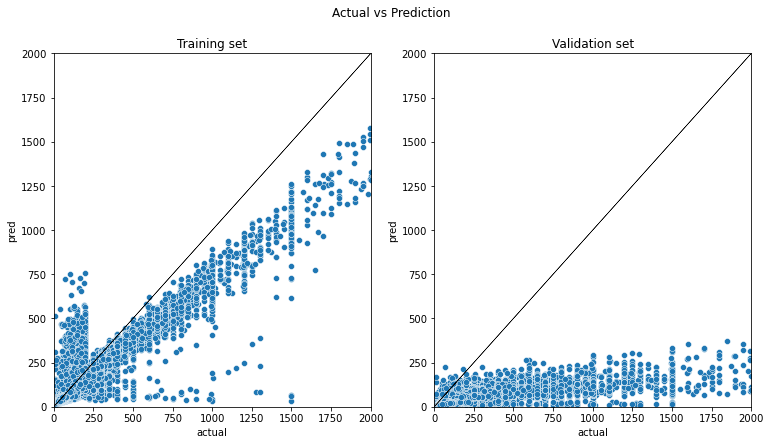

In [37]:
fig = plt.figure(figsize=(12.5, 6.5))
plt.suptitle('Actual vs Prediction')

plt.subplot(1, 2, 1)
ax = sns.scatterplot(pred_train['actual'], pred_train['pred'])
plt.plot(pred_train['actual'], pred_train['actual'], color='black', linewidth=0.5)
ax.set_xlim(0, 2000)
ax.set_ylim(0, 2000)
ax.set_title('Training set');
# plt.axes().set_aspect('equal')
plt.subplot(1, 2, 2)
ax = sns.scatterplot(pred_valid['actual'], pred_valid['pred'])
plt.plot(pred_valid['actual'], pred_valid['actual'], color='black', linewidth=0.5)
ax.set_xlim(0, 2000)
ax.set_ylim(0, 2000)
plt.title('Validation set');

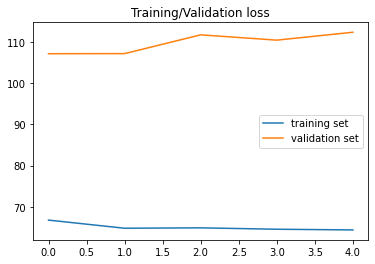

In [38]:
plt.plot(metrics['train_losses'], label='training set')
plt.plot(metrics['valid_losses'], label='validation set')
plt.title('Training/Validation loss')
plt.legend();

# Submission

In [39]:
pred_test_dfs = [pd.read_csv(os.path.join(output_dir, f'cv_fold{i + 1}_test.csv')) for i in range(N_SPLITS)]

In [40]:
pred_test = pd.concat(pred_test_dfs).groupby('id').sum()
pred_test = pred_test / N_SPLITS

In [41]:
pred_test.to_csv(os.path.join(output_dir, f'{EXPERIMENT}_submission.csv'), header=None)

# Visualization

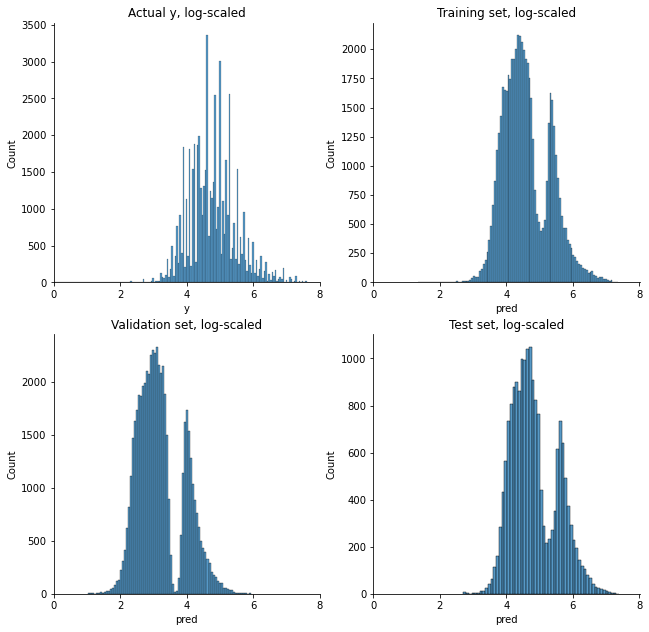

In [42]:
ylim_min, ylim_max = np.log(y_min * CLIP_LOWER_RATE), np.log(y_max * CLIP_UPPER_RATE)
fig = plt.figure(figsize=(10.5, 10.5))
plt.subplot(2, 2, 1)
ax = sns.histplot(y_log)
ax.set_title('Actual y, log-scaled')
ax.set_xlim(ylim_min, ylim_max)
sns.despine()

plt.subplot(2, 2, 2)
ax = sns.histplot(np.log(pred_train['pred']))
ax.set_title('Training set, log-scaled')
ax.set_xlim(ylim_min, ylim_max)
sns.despine()

plt.subplot(2, 2, 3)
ax = sns.histplot(np.log(pred_valid['pred']))
ax.set_title('Validation set, log-scaled')
ax.set_xlim(ylim_min, ylim_max)
sns.despine()

plt.subplot(2, 2, 4)
ax = sns.histplot(np.log(pred_test['pred']))
ax.set_title('Test set, log-scaled')
ax.set_xlim(ylim_min, ylim_max)
sns.despine()

fig.savefig(os.path.join(output_dir, 'figure.png'))

In [43]:
logger.debug('Complete({:.3f} seconds passed)'.format(time.time() - SINCE))

# Feature importance

In [44]:
pd.options.display.float_format = '{:.5f}'.format

In [45]:
models = []
for i, (train_idx, vaild_idx) in enumerate(splitter.split(X=X, y=y_labels)):
    num_fold = i + 1

    ## モデルの保存
    filepath_fold_model = os.path.join(output_dir, f'cv_fold{num_fold}_model.pkl')
    with open(filepath_fold_model, 'rb') as f:
        model = pickle.load(f)
    models.append(model)

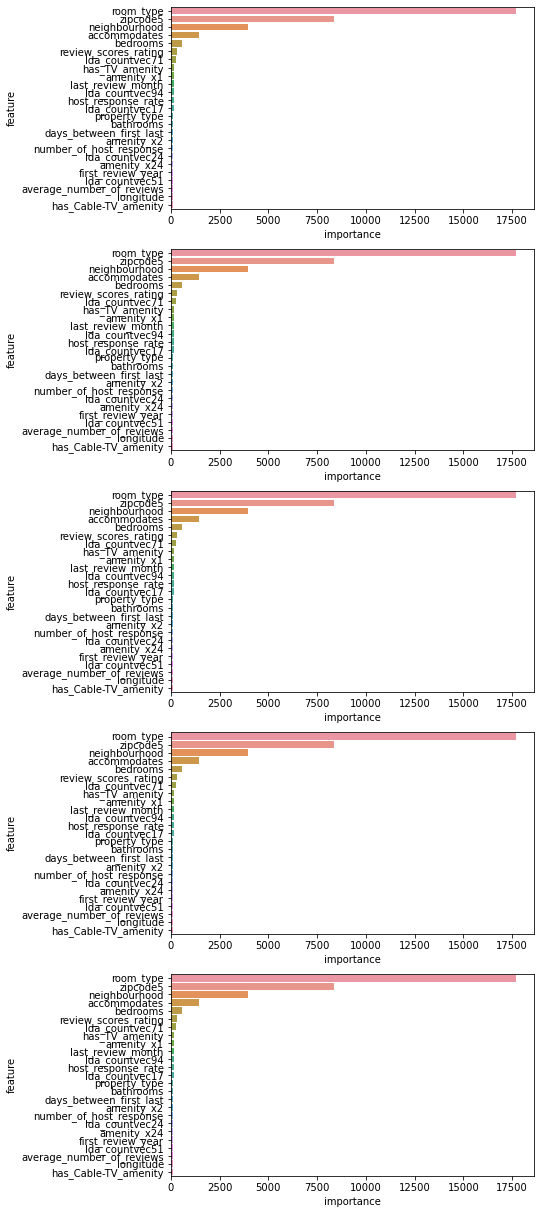

In [46]:
fig = plt.figure(figsize=(6.5, 21.5))
for i in range(N_SPLITS):
    plt.subplot(5, 1, i + 1)
    imp_df = pd.DataFrame(data=model['class0'].feature_importances_, columns=['importance'])
    imp_df['feature'] = X_train.columns.tolist()
    imp_df.sort_values(['importance', 'feature'], ascending=False, inplace=True)
    sns.barplot(data=imp_df.head(25), y='feature', x='importance')
fig.savefig(os.path.join(output_dir, 'feature_importance0.png'))

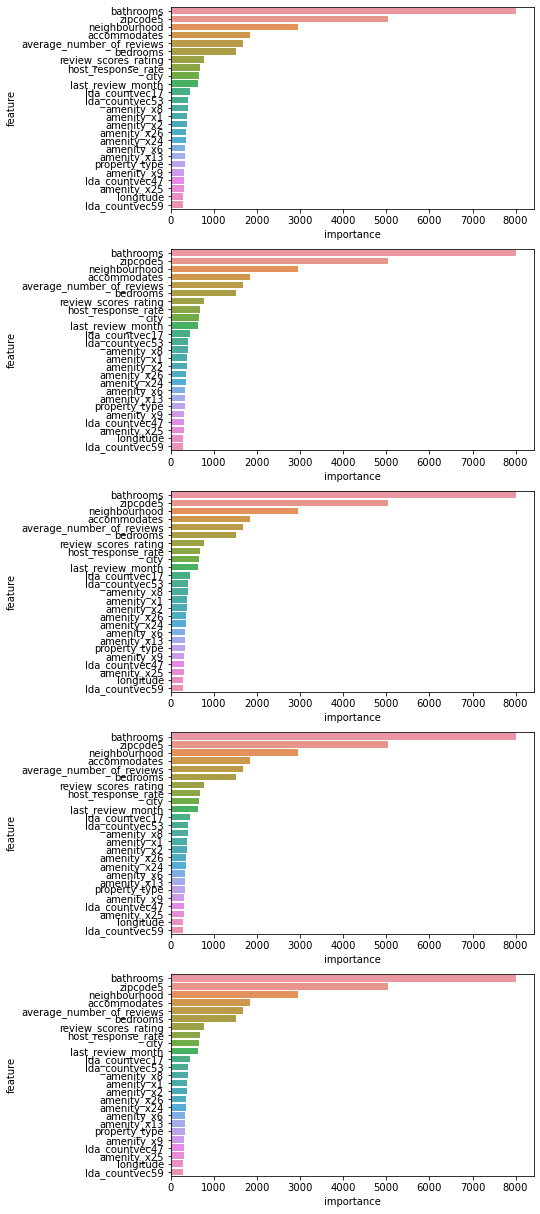

In [47]:
fig = plt.figure(figsize=(6.5, 21.5))
for i in range(N_SPLITS):
    plt.subplot(5, 1, i + 1)
    imp_df = pd.DataFrame(data=model['class1'].feature_importances_, columns=['importance'])
    imp_df['feature'] = X_train.columns.tolist()
    imp_df.sort_values(['importance', 'feature'], ascending=False, inplace=True)
    sns.barplot(data=imp_df.head(25), y='feature', x='importance')
fig.savefig(os.path.join(output_dir, 'feature_importance0.png'))

# Error

In [48]:
pred_valid = pd.read_csv(os.path.join(output_dir, 'prediction_valid.csv'))

In [49]:
pred_valid['diff'] = pred_valid['pred'] - pred_valid['actual']

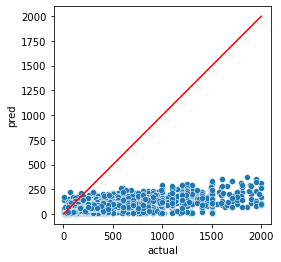

In [50]:
fig = plt.figure()
plt.axes().set_aspect('equal')
ax = sns.scatterplot(data=pred_valid, x='actual', y='pred')
ax = sns.lineplot(data=pred_valid, x='actual', y='actual', color='red')
fig.savefig(os.path.join(output_dir, 'compare_actual_prediction.png'))

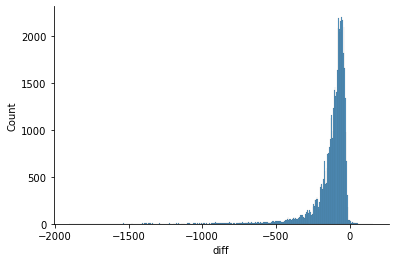

In [51]:
pred_valid.describe()
sns.histplot(data=pred_valid, x='diff')
sns.despine()

In [52]:
diff_df = pd.merge(X, pred_valid[['id', 'diff']]).set_index('id')

In [53]:
%%time
import sweetviz
report = sweetviz.analyze(diff_df, target_feat='diff', pairwise_analysis='off')
report.show_html(os.path.join(output_dir, ('sweetviz_error_report.html')))

                                             |                                             | [  0%]   00:00 ->…

Report C:\Users\nndropout\aiquest2021-assesment\experiments\05-14\sweetviz_error_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.
Wall time: 2min 4s


In [54]:
pd.options.display.max_rows = 50
pd.options.display.max_columns = diff_df.shape[1]

In [55]:
diff_df.sort_values('diff').head(50)

,accommodates,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,host_has_profile_pic,host_identity_verified,host_response_rate,instant_bookable,latitude,longitude,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,has_Coffee-maker_amenity,has__amenity,has_Beach-essentials_amenity,has_Ethernet-connection_amenity,has_Extra-pillows-and-blankets_amenity,has_Wide-entryway_amenity,has_Laptop-friendly-workspace_amenity,has_Pets-live-on-this-property_amenity,has_Lake-access_amenity,has_Crib_amenity,has_TV_amenity,has_Smoking-allowed_amenity,has_Waterfront_amenity,has_Other_amenity,has_Changing-table_amenity,has_Ground-floor-access_amenity,has_Oven_amenity,has_Baby-bath_amenity,has_Carbon-monoxide-detector_amenity,has_Paid-parking-off-premises_amenity,has_Bathtub_amenity,has_Heating_amenity,has_Pocket-wifi_amenity,has_Ski-inSki-out_amenity,has_Handheld-shower-head_amenity,has_Kitchen_amenity,has_Self-Check-In_amenity,has_24-hour-check-in_amenity,has_Long-term-stays-allowed_amenity,has_Free-parking-on-premises_amenity,has_Garden-or-backyard_amenity,has_Beachfront_amenity,has_translation-missing-en.hosting_amenity_49_amenity,has_Wide-clearance-to-shower-&-toilet_amenity,has_Firm-mattress_amenity,has_Dishwasher_amenity,has_translation-missing-en.hosting_amenity_50_amenity,has_High-chair_amenity,has_Cat(s)_amenity,has_EV-charger_amenity,has_Fireplace-guards_amenity,has_Essentials_amenity,has_BBQ-grill_amenity,has_Smartlock_amenity,has_Single-level-home_amenity,has_Buzzerwireless-intercom_amenity,has_Gym_amenity,has_Room-darkening-shades_amenity,has_Wireless-Internet_amenity,has_Suitable-for-events_amenity,has_Doorman-Entry_amenity,has_Lock-on-bedroom-door_amenity,has_Smoke-detector_amenity,has_Shampoo_amenity,has_Elevator-in-building_amenity,has_Table-corner-guards_amenity,has_Lockbox_amenity,has_Luggage-dropoff-allowed_amenity,has_Safety-card_amenity,has_Wide-hallway-clearance_amenity,has_Accessible-height-bed_amenity,has_Firm-matress_amenity,has_Microwave_amenity,has_Smart-lock_amenity,has_Doorman_amenity,has_Outlet-covers_amenity,has_Other-pet(s)_amenity,has_Familykid-friendly_amenity,has_Flat_amenity,has_Step-free-access_amenity,has_Cooking-basics_amenity,has_Washer_amenity,has_Hot-water_amenity,has_Air-purifier_amenity,has_Grab-rails-for-shower-and-toilet_amenity,has_First-aid-kit_amenity,has_Air-conditioning_amenity,has_Dryer_amenity,has_Disabled-parking-spot_amenity,has_Wheelchair-accessible_amenity,has_Keypad_amenity,has_Babysitter-recommendations_amenity,has_Host-greets-you_amenity,has_Hair-dryer_amenity,has_-smooth-pathway-to-front-door_amenity,has_Window-guards_amenity,has_Flat-smooth-pathway-to-front-door_amenity,has_Patio-or-balcony_amenity,has_Accessible-height-toilet_amenity,has_Dog(s)_amenity,has_Washer--Dryer_amenity,has_Wide-doorway_amenity,has_Wide-clearance-to-bed_amenity,has_Path-to-entrance-lit-at-night_amenity,has_Elevator_amenity,has_Cable-TV_amenity,has_Pack-’n-Playtravel-crib_amenity,has_Private-entrance_amenity,has_Refrigerator_amenity,has_Stair-gates_amenity,has_Indoor-fireplace_amenity,has_Bathtub-with-shower-chair_amenity,has_Internet_amenity,has_Iron_amenity,has_Breakfast_amenity,has_Children’s-dinnerware_amenity,has_Baby-monitor_amenity,has_Dishes-and-silverware_amenity,has_Fixed-grab-bars-for-shower-&-toilet_amenity,has_Private-living-room_amenity,has_Stove_amenity,has_Well-lit-path-to-entrance_amenity,has_Hot-tub_amenity,has_Hangers_amenity,has_Pool_amenity,has_Pets-allowed_amenity,has_Private-bathroom_amenity,has_Free-parking-on-street_amenity,has_Children’s-books-and-toys_amenity,has_Hot-water-kettle_amenity,has_Fire-extinguisher_amenity,has_Bed-linens_amenity,has_Game-console_amenity,has_Cleaning-before-checkout_amenity,days_between_first_last,average_number_of_reviews,number_of_host_response,average_number_of_host_response,zipcode_1st_digit,zipcode5,zipcode_imputed,has_thumbnail,first_review_year,first_review_month,host_since_year,host_since_month,last_rev

In [56]:
diff_df.sort_values('diff').tail(50)

,accommodates,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,host_has_profile_pic,host_identity_verified,host_response_rate,instant_bookable,latitude,longitude,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,has_Coffee-maker_amenity,has__amenity,has_Beach-essentials_amenity,has_Ethernet-connection_amenity,has_Extra-pillows-and-blankets_amenity,has_Wide-entryway_amenity,has_Laptop-friendly-workspace_amenity,has_Pets-live-on-this-property_amenity,has_Lake-access_amenity,has_Crib_amenity,has_TV_amenity,has_Smoking-allowed_amenity,has_Waterfront_amenity,has_Other_amenity,has_Changing-table_amenity,has_Ground-floor-access_amenity,has_Oven_amenity,has_Baby-bath_amenity,has_Carbon-monoxide-detector_amenity,has_Paid-parking-off-premises_amenity,has_Bathtub_amenity,has_Heating_amenity,has_Pocket-wifi_amenity,has_Ski-inSki-out_amenity,has_Handheld-shower-head_amenity,has_Kitchen_amenity,has_Self-Check-In_amenity,has_24-hour-check-in_amenity,has_Long-term-stays-allowed_amenity,has_Free-parking-on-premises_amenity,has_Garden-or-backyard_amenity,has_Beachfront_amenity,has_translation-missing-en.hosting_amenity_49_amenity,has_Wide-clearance-to-shower-&-toilet_amenity,has_Firm-mattress_amenity,has_Dishwasher_amenity,has_translation-missing-en.hosting_amenity_50_amenity,has_High-chair_amenity,has_Cat(s)_amenity,has_EV-charger_amenity,has_Fireplace-guards_amenity,has_Essentials_amenity,has_BBQ-grill_amenity,has_Smartlock_amenity,has_Single-level-home_amenity,has_Buzzerwireless-intercom_amenity,has_Gym_amenity,has_Room-darkening-shades_amenity,has_Wireless-Internet_amenity,has_Suitable-for-events_amenity,has_Doorman-Entry_amenity,has_Lock-on-bedroom-door_amenity,has_Smoke-detector_amenity,has_Shampoo_amenity,has_Elevator-in-building_amenity,has_Table-corner-guards_amenity,has_Lockbox_amenity,has_Luggage-dropoff-allowed_amenity,has_Safety-card_amenity,has_Wide-hallway-clearance_amenity,has_Accessible-height-bed_amenity,has_Firm-matress_amenity,has_Microwave_amenity,has_Smart-lock_amenity,has_Doorman_amenity,has_Outlet-covers_amenity,has_Other-pet(s)_amenity,has_Familykid-friendly_amenity,has_Flat_amenity,has_Step-free-access_amenity,has_Cooking-basics_amenity,has_Washer_amenity,has_Hot-water_amenity,has_Air-purifier_amenity,has_Grab-rails-for-shower-and-toilet_amenity,has_First-aid-kit_amenity,has_Air-conditioning_amenity,has_Dryer_amenity,has_Disabled-parking-spot_amenity,has_Wheelchair-accessible_amenity,has_Keypad_amenity,has_Babysitter-recommendations_amenity,has_Host-greets-you_amenity,has_Hair-dryer_amenity,has_-smooth-pathway-to-front-door_amenity,has_Window-guards_amenity,has_Flat-smooth-pathway-to-front-door_amenity,has_Patio-or-balcony_amenity,has_Accessible-height-toilet_amenity,has_Dog(s)_amenity,has_Washer--Dryer_amenity,has_Wide-doorway_amenity,has_Wide-clearance-to-bed_amenity,has_Path-to-entrance-lit-at-night_amenity,has_Elevator_amenity,has_Cable-TV_amenity,has_Pack-’n-Playtravel-crib_amenity,has_Private-entrance_amenity,has_Refrigerator_amenity,has_Stair-gates_amenity,has_Indoor-fireplace_amenity,has_Bathtub-with-shower-chair_amenity,has_Internet_amenity,has_Iron_amenity,has_Breakfast_amenity,has_Children’s-dinnerware_amenity,has_Baby-monitor_amenity,has_Dishes-and-silverware_amenity,has_Fixed-grab-bars-for-shower-&-toilet_amenity,has_Private-living-room_amenity,has_Stove_amenity,has_Well-lit-path-to-entrance_amenity,has_Hot-tub_amenity,has_Hangers_amenity,has_Pool_amenity,has_Pets-allowed_amenity,has_Private-bathroom_amenity,has_Free-parking-on-street_amenity,has_Children’s-books-and-toys_amenity,has_Hot-water-kettle_amenity,has_Fire-extinguisher_amenity,has_Bed-linens_amenity,has_Game-console_amenity,has_Cleaning-before-checkout_amenity,days_between_first_last,average_number_of_reviews,number_of_host_response,average_number_of_host_response,zipcode_1st_digit,zipcode5,zipcode_imputed,has_thumbnail,first_review_year,first_review_month,host_since_year,host_since_month,last_rev

In [57]:
diff_df.corr()

,accommodates,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,host_has_profile_pic,host_identity_verified,host_response_rate,instant_bookable,latitude,longitude,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,has_Coffee-maker_amenity,has__amenity,has_Beach-essentials_amenity,has_Ethernet-connection_amenity,has_Extra-pillows-and-blankets_amenity,has_Wide-entryway_amenity,has_Laptop-friendly-workspace_amenity,has_Pets-live-on-this-property_amenity,has_Lake-access_amenity,has_Crib_amenity,has_TV_amenity,has_Smoking-allowed_amenity,has_Waterfront_amenity,has_Other_amenity,has_Changing-table_amenity,has_Ground-floor-access_amenity,has_Oven_amenity,has_Baby-bath_amenity,has_Carbon-monoxide-detector_amenity,has_Paid-parking-off-premises_amenity,has_Bathtub_amenity,has_Heating_amenity,has_Pocket-wifi_amenity,has_Ski-inSki-out_amenity,has_Handheld-shower-head_amenity,has_Kitchen_amenity,has_Self-Check-In_amenity,has_24-hour-check-in_amenity,has_Long-term-stays-allowed_amenity,has_Free-parking-on-premises_amenity,has_Garden-or-backyard_amenity,has_Beachfront_amenity,has_translation-missing-en.hosting_amenity_49_amenity,has_Wide-clearance-to-shower-&-toilet_amenity,has_Firm-mattress_amenity,has_Dishwasher_amenity,has_translation-missing-en.hosting_amenity_50_amenity,has_High-chair_amenity,has_Cat(s)_amenity,has_EV-charger_amenity,has_Fireplace-guards_amenity,has_Essentials_amenity,has_BBQ-grill_amenity,has_Smartlock_amenity,has_Single-level-home_amenity,has_Buzzerwireless-intercom_amenity,has_Gym_amenity,has_Room-darkening-shades_amenity,has_Wireless-Internet_amenity,has_Suitable-for-events_amenity,has_Doorman-Entry_amenity,has_Lock-on-bedroom-door_amenity,has_Smoke-detector_amenity,has_Shampoo_amenity,has_Elevator-in-building_amenity,has_Table-corner-guards_amenity,has_Lockbox_amenity,has_Luggage-dropoff-allowed_amenity,has_Safety-card_amenity,has_Wide-hallway-clearance_amenity,has_Accessible-height-bed_amenity,has_Firm-matress_amenity,has_Microwave_amenity,has_Smart-lock_amenity,has_Doorman_amenity,has_Outlet-covers_amenity,has_Other-pet(s)_amenity,has_Familykid-friendly_amenity,has_Flat_amenity,has_Step-free-access_amenity,has_Cooking-basics_amenity,has_Washer_amenity,has_Hot-water_amenity,has_Air-purifier_amenity,has_Grab-rails-for-shower-and-toilet_amenity,has_First-aid-kit_amenity,has_Air-conditioning_amenity,has_Dryer_amenity,has_Disabled-parking-spot_amenity,has_Wheelchair-accessible_amenity,has_Keypad_amenity,has_Babysitter-recommendations_amenity,has_Host-greets-you_amenity,has_Hair-dryer_amenity,has_-smooth-pathway-to-front-door_amenity,has_Window-guards_amenity,has_Flat-smooth-pathway-to-front-door_amenity,has_Patio-or-balcony_amenity,has_Accessible-height-toilet_amenity,has_Dog(s)_amenity,has_Washer--Dryer_amenity,has_Wide-doorway_amenity,has_Wide-clearance-to-bed_amenity,has_Path-to-entrance-lit-at-night_amenity,has_Elevator_amenity,has_Cable-TV_amenity,has_Pack-’n-Playtravel-crib_amenity,has_Private-entrance_amenity,has_Refrigerator_amenity,has_Stair-gates_amenity,has_Indoor-fireplace_amenity,has_Bathtub-with-shower-chair_amenity,has_Internet_amenity,has_Iron_amenity,has_Breakfast_amenity,has_Children’s-dinnerware_amenity,has_Baby-monitor_amenity,has_Dishes-and-silverware_amenity,has_Fixed-grab-bars-for-shower-&-toilet_amenity,has_Private-living-room_amenity,has_Stove_amenity,has_Well-lit-path-to-entrance_amenity,has_Hot-tub_amenity,has_Hangers_amenity,has_Pool_amenity,has_Pets-allowed_amenity,has_Private-bathroom_amenity,has_Free-parking-on-street_amenity,has_Children’s-books-and-toys_amenity,has_Hot-water-kettle_amenity,has_Fire-extinguisher_amenity,has_Bed-linens_amenity,has_Game-console_amenity,has_Cleaning-before-checkout_amenity,days_between_first_last,average_number_of_reviews,number_of_host_response,average_number_of_host_response,zipcode_1st_digit,zipcode5,zipcode_imputed,has_thumbnail,first_review_year,first_review_month,host_since_year,host_since_month,last_rev

In [58]:
diff_df.corr().sort_values('diff')['diff'].head(50)

accommodates                           -0.47277
bedrooms                               -0.45143
bathrooms                              -0.41812
beds                                   -0.39510
room_type                              -0.26100
lda_countvec17                         -0.24402
has_Familykid-friendly_amenity         -0.18812
has_Indoor-fireplace_amenity           -0.16653
has_TV_amenity                         -0.15850
has_Cable-TV_amenity                   -0.15491
lda_countvec92                         -0.13918
has_Dryer_amenity                      -0.13899
amenity_x1                             -0.13674
has_Washer_amenity                     -0.13600
has_Suitable-for-events_amenity        -0.13542
lda_countvec47                         -0.12177
amenity_x3                             -0.11205
has_thumbnail                          -0.10840
lda_countvec71                         -0.09912
lda_countvec53                         -0.09690
lda_countvec6                          -

In [59]:
from lightgbm import LGBMRegressor
estimator = LGBMRegressor(random_state=SEED, n_jobs=-1, importance_type='gain').fit(diff_df.drop(columns=['diff']), diff_df['diff'])

In [60]:
imp_df = pd.DataFrame(data=estimator.feature_importances_, columns=['importance'])

In [61]:
imp_df['feature'] = estimator.feature_name_

In [62]:
imp_df.sort_values(['importance', 'feature'], ascending=False, inplace=True)
imp_df

,importance,feature
3,942891268.40625,bedrooms
1,534064982.00000,bathrooms
0,491981538.80469,accommodates
18,246960091.89844,room_type
13,221107351.00000,longitude
...,...,...
95,0.00000,has_Air-conditioning_amenity
107,0.00000,has_Accessible-height-toilet_amenity
79,0.00000,has_Accessible-height-bed_amenity
103,0.00000,has_-smooth-pathway-to-front-door_amenity


In [63]:
imp_df.to_csv(os.path.join(output_dir, 'diff_feature_importances.csv'), index=False)